Note that these tests are done on a laptop with a `GeForce RTX 2070 with Max-Q Design`, which has tensor cores.

I'm assuming data will be coming in as a 384 x 512 8-bit numpy array. Tests will involve the total time it takes to preprocess data, copy it to GPU, perform inference, copy data back, and then get a final segmentation mask. 

Run initialization cells to load the test image.

# Get data

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
X = np.fromfile('test.raw', dtype=np.uint8).reshape(384, 512)

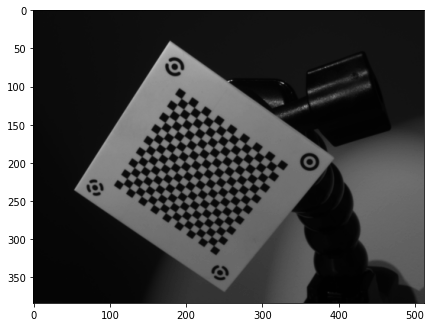

In [6]:
plt.figure(figsize=(7,7))
plt.imshow(X, vmin=0, vmax=255, cmap='gray')

# Original Pytorch Model

In [4]:
import torch
from pathlib import Path

In [5]:
import sys
sys.path.append('../fiducial_detect/')
from fiducial_detect.models import *

Disable Gradients

In [6]:
torch.set_grad_enabled(False) 

Load model

In [7]:
in_channels  = 1
out_channels = 5
layout_encoder = [[[48,5,2,2]],
                  [[48,3,1,1],[48,3,2,1]],
                  [[60,3,1,1],[60,3,2,1]],
                  [[72,3,1,1],[144,3,2,1]]]
model = UNET(get_encoder(in_channels, layout_encoder), out_channels)
model.load_state_dict(torch.load(Path('../fiducial_detect/training/attempt_2/checkpoints/best.pth'))['model'])
model = model.cuda()
model = model.eval()

Allocate buffers

In [8]:
X_h_uint8 = torch.empty((1, 1, 384, 512), dtype=torch.uint8, pin_memory=True)
X_d_uint8 = torch.empty((1, 1, 384, 512), dtype=torch.uint8, device='cuda')
X_d_float = torch.empty((1, 1, 384, 512), dtype=torch.float, device='cuda')
y_d_uint8 = torch.empty((384, 512),       dtype=torch.uint8, device='cuda')
y         = torch.empty((384, 512),       dtype=torch.uint8, pin_memory=True)

Inference

In [9]:
def _inference():
    X_h_uint8.copy_(torch.from_numpy(X))
    X_d_uint8.copy_(X_h_uint8)
    X_d_float.copy_(X_d_uint8)
    X_d_float.mul_(0.00784313725)
    X_d_float.add_(-1)
    y_d_int64 = model(X_d_float).argmax(dim=1).squeeze(dim=0)
    y_d_uint8.copy_(y_d_int64)
    y.copy_(y_d_uint8)

In [10]:
_inference()

In [11]:
%%timeit
_inference()

7.91 ms ± 11.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


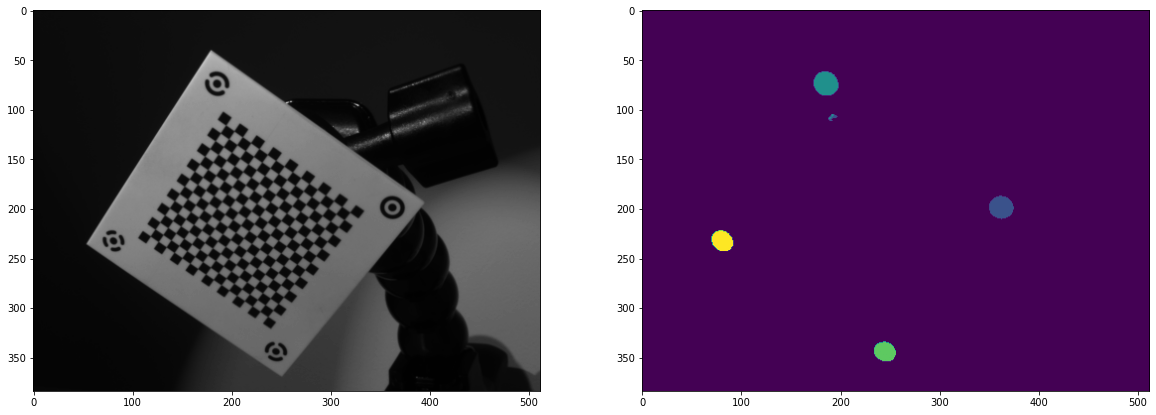

In [12]:
_, axs = plt.subplots(1, 2, figsize=(20,10))
axs[0].imshow(X, vmin=0, vmax=255, cmap='gray')
axs[1].imshow(y, vmin=0, vmax=4)

# Original Pytorch Model with Half Precision

In [4]:
import torch
from pathlib import Path

In [5]:
import sys
sys.path.append('../fiducial_detect/')
from fiducial_detect.models import *

Disable Gradients

In [6]:
torch.set_grad_enabled(False) 

Load model

In [7]:
in_channels  = 1
out_channels = 5
layout_encoder = [[[48,5,2,2]],
                  [[48,3,1,1],[48,3,2,1]],
                  [[60,3,1,1],[60,3,2,1]],
                  [[72,3,1,1],[144,3,2,1]]]
model = UNET(get_encoder(in_channels, layout_encoder), out_channels)
model.load_state_dict(torch.load(Path('../fiducial_detect/training/attempt_2/checkpoints/best.pth'))['model'])
model = model.half()
model = model.cuda()
model = model.eval()

Allocate buffers

In [8]:
X_h_uint8 = torch.empty((1, 1, 384, 512), dtype=torch.uint8, pin_memory=True)
X_d_uint8 = torch.empty((1, 1, 384, 512), dtype=torch.uint8, device='cuda')
X_d_half  = torch.empty((1, 1, 384, 512), dtype=torch.half,  device='cuda')
y_d_uint8 = torch.empty((384, 512),       dtype=torch.uint8, device='cuda')
y         = torch.empty((384, 512),       dtype=torch.uint8, pin_memory=True)

Inference

In [9]:
def _inference():
    X_h_uint8.copy_(torch.from_numpy(X))
    X_d_uint8.copy_(X_h_uint8)
    X_d_half .copy_(X_d_uint8)
    X_d_half .mul_(0.00784313725)
    X_d_half .add_(-1)
    y_d_int64 = model(X_d_half).argmax(dim=1).squeeze(dim=0)
    y_d_uint8.copy_(y_d_int64)
    y.copy_(y_d_uint8)

In [10]:
_inference()

In [11]:
%%timeit
_inference()

6.88 ms ± 53.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


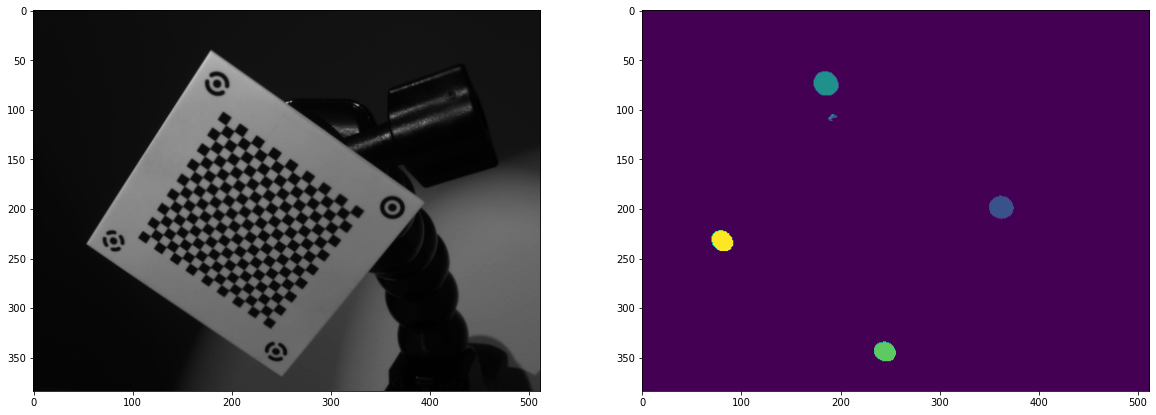

In [13]:
_, axs = plt.subplots(1, 2, figsize=(20,10))
axs[0].imshow(X, vmin=0, vmax=255, cmap='gray')
axs[1].imshow(y, vmin=0, vmax=4)

# Pruned pytorch model

In [4]:
import torch
from pathlib import Path
from test_fast_inference.pytorch_tensorrt_conversion import *

Disable Gradients

In [5]:
torch.set_grad_enabled(False) 

Load model

In [6]:
in_channels  = 1
out_channels = 5
layout_encoder = [[[16,5,2,2]],
                  [[16,3,1,1],[16,3,2,1]],
                  [[16,3,1,1],[16,3,2,1]],
                  [[16,3,1,1],[16,3,2,1]]]
model = UNET_TRT(get_encoder(in_channels, layout_encoder), out_channels)
model.load_state_dict(torch.load(Path('training/attempt_2/checkpoints/best.pth'))['model'])
model = model.cuda()
model = model.eval()

Allocate buffers

In [7]:
X_h_uint8 = torch.empty((1, 1, 384, 512), dtype=torch.uint8, pin_memory=True)
X_d_uint8 = torch.empty((1, 1, 384, 512), dtype=torch.uint8, device='cuda')
X_d_float = torch.empty((1, 1, 384, 512), dtype=torch.float, device='cuda')
y_d_uint8 = torch.empty((384, 512),       dtype=torch.uint8, device='cuda')
y         = torch.empty((384, 512),       dtype=torch.uint8, pin_memory=True)

Inference

In [8]:
def _inference():
    X_h_uint8.copy_(torch.from_numpy(X))
    X_d_uint8.copy_(X_h_uint8)
    X_d_float.copy_(X_d_uint8)
    X_d_float.mul_(0.00784313725)
    X_d_float.add_(-1)
    y_d_int64 = model(X_d_float).argmax(dim=1).squeeze(dim=0)
    y_d_uint8.copy_(y_d_int64)
    y.copy_(y_d_uint8)

In [9]:
_inference()

In [10]:
%%timeit
_inference()

3.8 ms ± 40.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


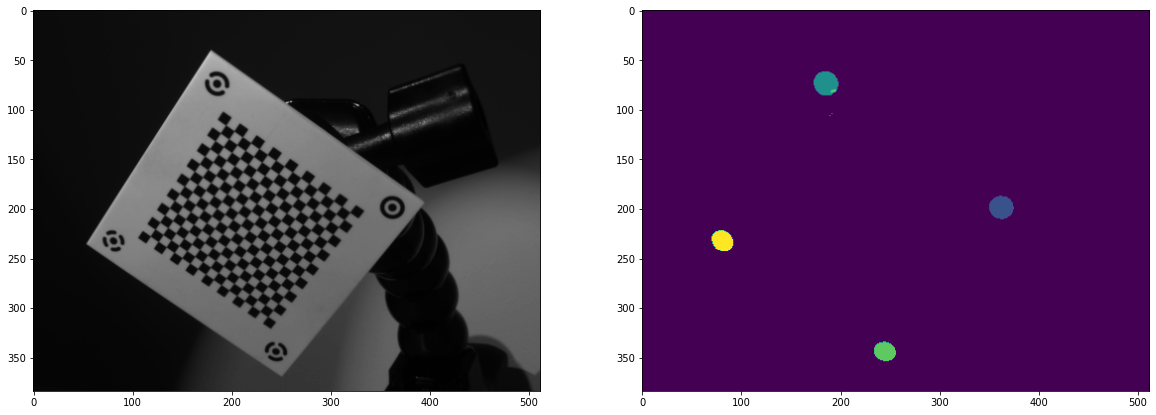

In [11]:
_, axs = plt.subplots(1, 2, figsize=(20,10))
axs[0].imshow(X, vmin=0, vmax=255, cmap='gray')
axs[1].imshow(y, vmin=0, vmax=4)

# Pruned TensorRT model (32-bit)

In [4]:
import torch
import tensorrt as trt

from pathlib import Path

Force loading of libnvinfer plugins

In [5]:
trt.init_libnvinfer_plugins(None,'')

True

Load engine

In [6]:
runtime = trt.Runtime(trt.Logger(trt.Logger.VERBOSE))
with open('training/attempt_2/model_32.engine', 'rb') as f:
    engine = runtime.deserialize_cuda_engine(f.read())
context = engine.create_execution_context()

Allocate buffers

In [7]:
X_h_uint8 = torch.empty((1, 1, 384, 512), dtype=torch.uint8, pin_memory=True)
X_d_uint8 = torch.empty((1, 1, 384, 512), dtype=torch.uint8, device='cuda')
X_d_float = torch.empty((1, 1, 384, 512), dtype=torch.float, device='cuda')
y_d_float = torch.empty((1, 5, 384, 512), dtype=torch.float, device='cuda')
y_d_uint8 = torch.empty((384, 512),       dtype=torch.uint8, device='cuda')
y         = torch.empty((384, 512),       dtype=torch.uint8, pin_memory=True)

Inference

In [8]:
def _inference():
    X_h_uint8.copy_(torch.from_numpy(X))
    X_d_uint8.copy_(X_h_uint8)
    X_d_float.copy_(X_d_uint8)
    X_d_float.mul_(0.00784313725)
    X_d_float.add_(-1)
    context.execute_v2(bindings=[int(X_d_float.data_ptr()), int(y_d_float.data_ptr())])    
    y_d_int64 = y_d_float.argmax(dim=1).squeeze(dim=0)
    y_d_uint8.copy_(y_d_int64)
    y.copy_(y_d_uint8)

In [9]:
_inference()

In [10]:
%%timeit
_inference()

1.62 ms ± 21.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


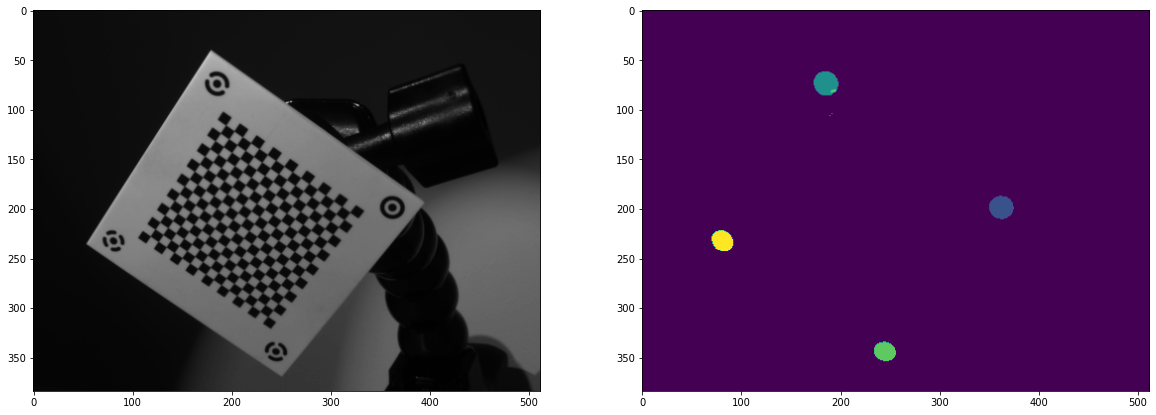

In [11]:
_, axs = plt.subplots(1, 2, figsize=(20,10))
axs[0].imshow(X, vmin=0, vmax=255, cmap='gray')
axs[1].imshow(y, vmin=0, vmax=4)

# Pruned TensorRT model (16-bit)

In [4]:
import torch
import tensorrt as trt

from pathlib import Path

Force loading of libnvinfer plugins

In [5]:
trt.init_libnvinfer_plugins(None,'')

True

Load engine

In [6]:
runtime = trt.Runtime(trt.Logger(trt.Logger.VERBOSE))
with open('training/attempt_2/model_16.engine', 'rb') as f:
    engine = runtime.deserialize_cuda_engine(f.read())
context = engine.create_execution_context()

Allocate buffers

In [7]:
X_h_uint8 = torch.empty((1, 1, 384, 512), dtype=torch.uint8, pin_memory=True)
X_d_uint8 = torch.empty((1, 1, 384, 512), dtype=torch.uint8, device='cuda')
X_d_float = torch.empty((1, 1, 384, 512), dtype=torch.float, device='cuda')
y_d_float = torch.empty((1, 5, 384, 512), dtype=torch.float, device='cuda')
y_d_uint8 = torch.empty((384, 512),       dtype=torch.uint8, device='cuda')
y         = torch.empty((384, 512),       dtype=torch.uint8, pin_memory=True)

Inference

In [8]:
def _inference():
    X_h_uint8.copy_(torch.from_numpy(X))
    X_d_uint8.copy_(X_h_uint8)
    X_d_float.copy_(X_d_uint8)
    X_d_float.mul_(0.00784313725)
    X_d_float.add_(-1)
    context.execute_v2(bindings=[int(X_d_float.data_ptr()), int(y_d_float.data_ptr())])    
    y_d_int64 = y_d_float.argmax(dim=1).squeeze(dim=0)
    y_d_uint8.copy_(y_d_int64)
    y.copy_(y_d_uint8)

In [9]:
_inference()

In [10]:
%%timeit
_inference()

1.33 ms ± 2.63 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


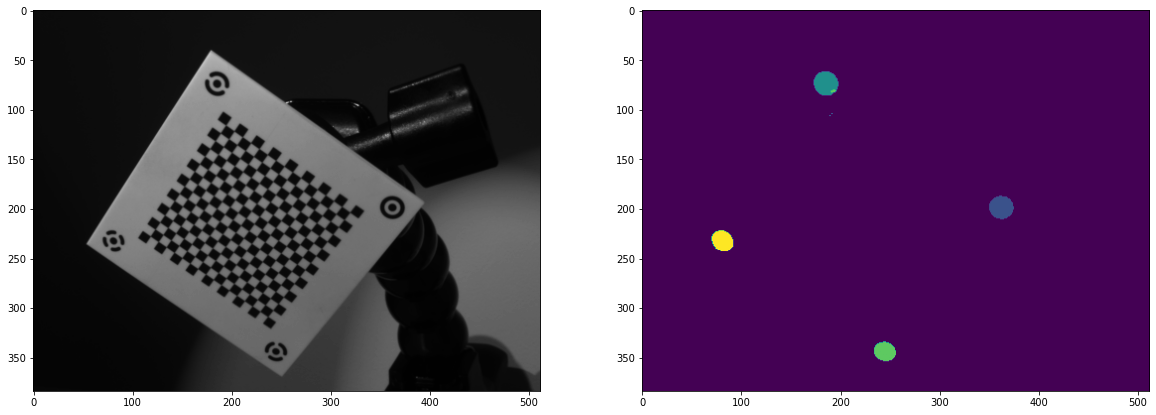

In [11]:
_, axs = plt.subplots(1, 2, figsize=(20,10))
axs[0].imshow(X, vmin=0, vmax=255, cmap='gray')
axs[1].imshow(y, vmin=0, vmax=4)

# Pruned TensorRT model (8-bit)

In [4]:
import torch
import tensorrt as trt

from pathlib import Path

Force loading of libnvinfer plugins

In [5]:
trt.init_libnvinfer_plugins(None,'')

True

Load engine

In [6]:
runtime = trt.Runtime(trt.Logger(trt.Logger.VERBOSE))
with open('training/attempt_2/model_8.engine', 'rb') as f:
    engine = runtime.deserialize_cuda_engine(f.read())
context = engine.create_execution_context()

Allocate buffers

In [7]:
X_h_uint8 = torch.empty((1, 1, 384, 512), dtype=torch.uint8, pin_memory=True)
X_d_uint8 = torch.empty((1, 1, 384, 512), dtype=torch.uint8, device='cuda')
X_d_float = torch.empty((1, 1, 384, 512), dtype=torch.float, device='cuda')
y_d_float = torch.empty((1, 5, 384, 512), dtype=torch.float, device='cuda')
y_d_uint8 = torch.empty((384, 512),       dtype=torch.uint8, device='cuda')
y         = torch.empty((384, 512),       dtype=torch.uint8, pin_memory=True)

Inference

In [8]:
def _inference():
    X_h_uint8.copy_(torch.from_numpy(X))
    X_d_uint8.copy_(X_h_uint8)
    X_d_float.copy_(X_d_uint8)
    X_d_float.mul_(0.00784313725)
    X_d_float.add_(-1)
    context.execute_v2(bindings=[int(X_d_float.data_ptr()), int(y_d_float.data_ptr())])    
    y_d_int64 = y_d_float.argmax(dim=1).squeeze(dim=0)
    y_d_uint8.copy_(y_d_int64)
    y.copy_(y_d_uint8)

In [9]:
_inference()

In [10]:
%%timeit
_inference()

1.03 ms ± 12.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


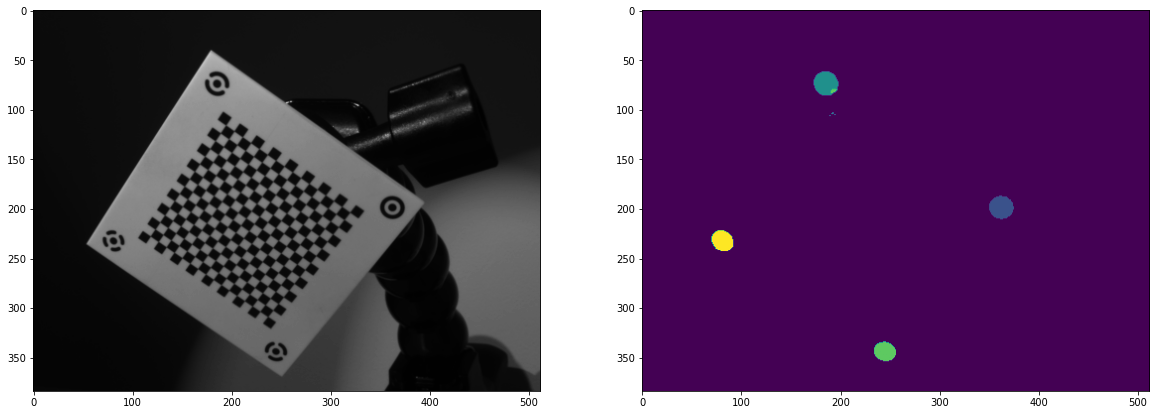

In [11]:
_, axs = plt.subplots(1, 2, figsize=(20,10))
axs[0].imshow(X, vmin=0, vmax=255, cmap='gray')
axs[1].imshow(y, vmin=0, vmax=4)

# Compare

```
Original pytorch model                - 7.91 ms
Original half precision pytorch model - 6.88 ms
Pruned pytorch model                  - 3.80 ms
Pruned tensorrt model (32 bit)        - 1.62 ms
Pruned tensorrt model (16 bit)        - 1.33 ms
Pruned tensorrt model (8 bit)         - 1.03 ms
```

I think one takeaway here is that copying your data in minimal precision, doing all algorithmic work on the gpu, and then copying back in minimal precision can really speed up inference performance. Close to `1 ms` inference performance is possible here.